<h1 style="text-align: center; font-size: 50px;">Multimodal RAG Chatbot with Langchain, Torch, Transformers</h1>

Retrieval-Augmented Generation (RAG) is an architectural approach that can enhance the effectiveness of large language model (LLM) applications using customized data. In this example, we use LangChain, an orchestrator for language pipelines, to build an assistant capable of loading information from a web page and use it for answering user questions. We'll leverage torch and transformers for multimodal model support in Python. We'll also use the MLFlow platform to evaluate and trace the LLM responses (in `register-workflow.ipynb`)

# Notebook Overview
- Configuring the Environment
- Data Loading & Cleaning
- Setup Embeddings & Vector Store
- Retrieval Function
- Model Setup & Chain Creation

## Step 0: Configuring the Environment

In this step, we import all the necessary libraries and internal components required to run the RAG pipeline, including modules for notebook parsing, embedding generation, vector storage, and code generation with LLMs.


By using our Local GenAI workspace image, many of the necessary libraries to work with RAG already come pre-installed - in our case, we just need to extra support for multimodal processes.

In [1]:
import time
import os 
from pathlib import Path
import sys
import logging

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Create logger
logger = logging.getLogger("multimodal_rag_logger")
logger.setLevel(logging.INFO)

formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S") 
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.propagate = False

In [2]:
start_time = time.time()  

logger.info('Notebook execution started.')

2025-07-29 18:18:02 - INFO - Notebook execution started.


In [3]:
%pip install -r ../requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
# === Standard Library Imports ===
import gc
import json
import math
import hashlib
import shutil
import warnings
import numpy as np
from pathlib import Path
from rank_bm25 import BM25Okapi
from statistics import mean
from typing import Any, Dict, List, Optional, TypedDict
from IPython.display import display, Markdown
from collections import defaultdict

# === Third-Party Library Imports ===
import mlflow
import torch
from langchain_core.embeddings import Embeddings
from langchain.schema.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from PIL import Image as PILImage
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer, BitsAndBytesConfig, SiglipModel, SiglipProcessor


# === Project-Specific Imports ===
from src.components import SemanticCache, SiglipEmbeddings
from src.wiki_pages_clone import orchestrate_wiki_clone
from src.utils import (
    configure_hf_cache,
    multimodal_rag_asset_status,
    load_config,
    load_secrets,
    load_mm_docs_clean,
    display_images,
)

2025-07-29 18:18:22.775531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-29 18:18:22.790515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753813102.808547    1381 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753813102.814104    1381 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753813102.825877    1381 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [5]:
warnings.filterwarnings("ignore")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda



### Verify Assets

In [7]:
CONFIG_PATH = "../configs/config.yaml"
SECRETS_PATH = "../configs/secrets.yaml"

LOCAL_MODEL: Path = Path("/home/jovyan/datafabric/InternVL3-8B-Instruct")
CONTEXT_DIR: Path = Path("../data/context")             
CHROMA_DIR: Path = Path("../data/chroma_store")     
CACHE_DIR: Path = CHROMA_DIR / "semantic_cache"
MANIFEST_PATH: Path = CHROMA_DIR / "manifest.json"

IMAGE_DIR = CONTEXT_DIR / "images"
WIKI_METADATA_DIR = CONTEXT_DIR / "wiki_flat_structure.json"

DEMO_FOLDER = "../demo"

CHROMA_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

multimodal_rag_asset_status(
    local_model_path=LOCAL_MODEL,
    config_path=CONFIG_PATH,
    secrets_path=SECRETS_PATH,
    wiki_metadata_dir=WIKI_METADATA_DIR,
    context_dir=CONTEXT_DIR,
    chroma_dir=CHROMA_DIR,
    cache_dir=CACHE_DIR,
    manifest_path=MANIFEST_PATH
)

2025-07-29 18:18:30 - INFO - Local Model is properly configured. 
2025-07-29 18:18:30 - INFO - Config is properly configured. 
2025-07-29 18:18:30 - INFO - Secrets is not properly configured. Please check if the secrets.yaml was properly configured in your project on AI Studio. If you are using secrets manager you can ignore this message.
2025-07-29 18:18:30 - INFO - wiki_flat_structure.json is properly configured. 
2025-07-29 18:18:30 - INFO - CONTEXT is properly configured. 
2025-07-29 18:18:30 - INFO - CHROMA is properly configured. 
2025-07-29 18:18:30 - INFO - CACHE is properly configured. 
2025-07-29 18:18:30 - INFO - MANIFEST is properly configured. 


### Config Loading

In this section, we load configuration parameters from the YAML file in the configs folder.

- **config.yaml**: Contains non-sensitive configuration parameters like model sources and URLs

In [8]:
config = load_config(CONFIG_PATH)

### Config HuggingFace Caches

In the next cell, we configure HuggingFace cache, so that all the models downloaded from them are persisted locally, even after the workspace is closed. This is a future desired feature for AI Studio and the GenAI addon.

In [9]:
# Configure HuggingFace cache
configure_hf_cache()

In [10]:
%%time

# Initialize HuggingFace Embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/e5-large-v2",
    cache_folder="/tmp/hf_cache"
)

CPU times: user 4.09 s, sys: 3.4 s, total: 7.49 s
Wall time: 11 s


## Step 1: Data Loading & Cleaning

`wiki_flat_structure.json` is a custom json metadata for ADO Wiki data. It is flatly structured, with keys for filepath, md content, and a list of images. We also have a image folder that contains all the images for every md page. We directly scrape this data from ADO and perform any cleanup if necessary.

- **secrets.yaml**: For Freemium users, use secrets.yaml to store your sensitive data like API Keys. If you are a Premium user, you can use secrets manager.
- **AIS Secrets Manager**: For Paid users, use the secrets manager in the `Project Setup` tab to configure your API key.

In [11]:
%%time

ADO_PAT = os.getenv("AIS_ADO_TOKEN")
if not ADO_PAT:
    logger.info("Environment variable not found... Secrets Manager not properly set. Falling to secrets.yaml.")
    try:
        secrets = load_secrets(SECRETS_PATH)
        ADO_PAT = secrets.get('AIS_ADO_TOKEN')
    except NameError:
        logger.error("The 'secrets' object is not defined or available.")

try:
    orchestrate_wiki_clone(
        pat=ADO_PAT,
        config=config,
        output_dir=CONTEXT_DIR
    )
    logger.info("✅ Wiki data preparation step completed successfully.")

except Exception as e:
    logger.error("Halting notebook execution due to a critical error in the wiki preparation step.")

2025-07-29 18:18:41 - INFO - Starting ADO Wiki clone process...
2025-07-29 18:18:41 - INFO - Cloning wiki 'Phoenix-DS-Platform.wiki' to temporary directory: /tmp/tmp_axltcym
2025-07-29 18:18:59 - INFO - Scanning for Markdown files...
2025-07-29 18:18:59 - INFO - → Found 567 Markdown pages.
2025-07-29 18:18:59 - INFO - Copying referenced images to ../data/context/images...
2025-07-29 18:19:32 - INFO - → 741 unique images copied.
2025-07-29 18:19:32 - INFO - Assembling flat JSON structure...
2025-07-29 18:19:32 - INFO - ✅ Wiki data successfully cloned to ../data/context
2025-07-29 18:19:33 - INFO - Cleaned up temporary directory: /tmp/tmp_axltcym
2025-07-29 18:19:33 - INFO - ✅ Wiki data preparation step completed successfully.


CPU times: user 3.11 s, sys: 3.69 s, total: 6.8 s
Wall time: 51.3 s


In [12]:
%%time

WIKI_METADATA_DIR   = Path(WIKI_METADATA_DIR)
IMAGE_DIR = Path(IMAGE_DIR)

mm_raw_docs = load_mm_docs_clean(WIKI_METADATA_DIR, Path(IMAGE_DIR))

def log_stage(name: str, docs: List[Document]):
    logger.info(f"{name}: {len(docs)} docs, avg_tokens={sum(len(d.page_content) for d in docs)/len(docs):.0f}")
log_stage("Docs loaded", mm_raw_docs)

2025-07-29 18:19:36 - WARNING - ⚠️ 94 broken image refs filtered out
2025-07-29 18:19:36 - INFO - Docs loaded: 567 docs, avg_tokens=3101


CPU times: user 170 ms, sys: 226 ms, total: 396 ms
Wall time: 3.96 s


## Step 2: Creation of Chunks

Here, we split the loaded documents into chunks, so we have smaller and more specific texts to add to our vector database. 

We chunk based on header style, and then within each header style we futher chunk based on the provided chunk size. Each chunk retains the page name, which preserves the relevance of each chunk. 

In [13]:
%%time

def chunk_documents(
    docs,
    chunk_size: int = 1200,
    overlap: int = 200,
) -> list[Document]:
    """
    1) Split each wiki page on Markdown headers (#, ## …) to keep logical
       sections together.
    2) Recursively break long sections to <= `chunk_size` chars with `overlap`.
    3) Prefix every chunk with its page-title and store the title in metadata.
    """
    header_splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=[("#", "title"), ("##", "section")]
    )
    recursive_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
    )

    all_chunks: list[Document] = []
    for doc in docs:
        page_title = Path(doc.metadata["source"]).stem.replace("-", " ")

        # 1️. section‑level split (returns list[Document])
        section_docs = header_splitter.split_text(doc.page_content)

        for section in section_docs:
            # 2. size‑based split inside each section
            tiny_texts = recursive_splitter.split_text(section.page_content)

            for idx, tiny in enumerate(tiny_texts):
                all_chunks.append(
                    Document(
                        page_content=f"{page_title}\n\n{tiny.strip()}",
                        metadata={
                            "title": page_title,
                            "source": doc.metadata["source"],
                            "section_header": section.metadata.get("header", ""),
                            "chunk_id": idx,
                        },
                    )
                )
    if all_chunks:
        avg_len = int(mean(len(c.page_content) for c in all_chunks))
        logger.info(
            "Chunking complete: %d docs → %d chunks (avg %d chars)",
            len(docs),
            len(all_chunks),
            avg_len,
        )
    else:
        logger.warning("Chunking produced zero chunks for %d docs", len(docs))

    return all_chunks

splits = chunk_documents(mm_raw_docs)

2025-07-29 18:19:37 - INFO - Chunking complete: 567 docs → 2616 chunks (avg 718 chars)


CPU times: user 192 ms, sys: 426 μs, total: 192 ms
Wall time: 189 ms


## Step 3: Setup Embeddings & Vector Store
Here we setup Siglip for Image embeddings, and also transform our cleaned text chunks into embeddings to be stored in Chroma. We store the chroma data locally on the disk to reduce memory usage. 

### Setup Text ChromaDB

In [14]:
%%time

# 1) TEXT store
def _current_manifest() -> Dict[str, str]:
    """
    Returns a dictionary mapping every context JSON file to its SHA256 content hash.
    This allows detecting changes in file content, not just filenames.
    """
    manifest = {}
    json_files = sorted(CONTEXT_DIR.rglob("*.json"))

    for file_path in json_files:
        try:
            with open(file_path, "rb") as f:
                file_bytes = f.read()
                file_hash = hashlib.sha256(file_bytes).hexdigest()
                manifest[str(file_path.resolve())] = file_hash
        except IOError as e:
            logger.error(f"Could not read file {file_path} for hashing: {e}")
    return manifest

def _needs_rebuild() -> bool:
    """
    Determines if the ChromaDB needs to be rebuilt.
    A rebuild is needed if:
    1. The Chroma directory or manifest file doesn't exist.
    2. The manifest is unreadable.
    3. The stored file hashes in the manifest do not match the current file hashes.
    """
    if not CHROMA_DIR.exists() or not MANIFEST_PATH.exists():
        logger.info("Chroma directory or manifest not found. A rebuild is required.")
        return True
    try:
        old_manifest = json.loads(MANIFEST_PATH.read_text())
    except Exception as e:
        logger.warning(f"Could not read manifest file. A rebuild is required. Error: {e}")
        return True

    current_manifest = _current_manifest()
    if old_manifest != current_manifest:
        logger.info("Data content has changed. A rebuild is required.")
        return True

    return False

def _save_manifest(manifest: Dict[str, str]) -> None:
    """Saves the current data manifest (mapping file paths to hashes) to disk."""
    CHROMA_DIR.mkdir(parents=True, exist_ok=True)
    MANIFEST_PATH.write_text(json.dumps(manifest, indent=2))

def _build_text_db() -> Chroma:
    collection = "mm_text"
    # The rebuild check is now done outside this function.
    # We check if the directory exists. If not, we build.
    if not CHROMA_DIR.exists() or not (CHROMA_DIR / "chroma.sqlite3").exists():
        logger.info("Creating new text context index in %s ...", CHROMA_DIR)
        chroma = Chroma.from_documents(
            documents          = splits,
            embedding          = embeddings,
            collection_name    = collection,
            persist_directory  = str(CHROMA_DIR),
        )
        return chroma

    logger.info("Loading existing Chroma index from %s", CHROMA_DIR)
    return Chroma(
        collection_name   = collection,
        persist_directory = str(CHROMA_DIR),
        embedding_function= embeddings,
    )
    
# Check if a rebuild is needed and wipe the old DB if so.
# This ensures both the text and image databases are rebuilt from scratch.
if _needs_rebuild():
    logger.warning("REBUILDING: Wiping old ChromaDB store at %s", CHROMA_DIR)
    if CHROMA_DIR.exists():
        shutil.rmtree(CHROMA_DIR)
    # Save the new manifest immediately after deciding to rebuild
    _save_manifest(_current_manifest())

# Now, initialize your databases. They will be created fresh if they were just deleted.
text_db = _build_text_db()
CACHE_DIR.mkdir(parents=True, exist_ok=True)

2025-07-29 18:19:37 - INFO - Loading existing Chroma index from ../data/chroma_store


CPU times: user 662 ms, sys: 47.1 ms, total: 709 ms
Wall time: 1.08 s


### Setup Image ChromaDB

In [15]:
%%time

#  Helper: walk all docs once and gather *unique* image vectors + metadata
def _collect_image_vectors():
    """
    Scans every wiki page for image references and returns three parallel lists:
        img_paths : list[str]   → full file-system paths (for SigLIP)
        img_ids   : list[str]   → unique key per (page, image) pair
        img_meta  : list[dict]  → {"source": wiki_page, "image": file_name}
    Runs in < 1s even for thousands of docs.
    """
    img_paths, img_ids, img_meta = [], [], []
    seen = set()

    for doc in mm_raw_docs:                         # raw wiki pages
        src = doc.metadata["source"]
        for name in doc.metadata.get("images", []): # list[str]
            img_id = f"{src}::{name}"
            if img_id in seen:
                continue                            # de‑dupe
            seen.add(img_id)

            img_paths.append(str(IMAGE_DIR / name))
            img_ids.append(img_id)
            img_meta.append({"source": src, "image": name})

    return img_paths, img_ids, img_meta

siglip_embeddings = SiglipEmbeddings("google/siglip2-base-patch16-224", DEVICE)

# 2) IMAGE store
image_db = Chroma(
    collection_name    = "mm_image",
    persist_directory  = str(CHROMA_DIR),   # SAME dir as text db
    embedding_function = siglip_embeddings, # <-- class you kept
)

# Populate vectors *only* if it is empty
if not image_db._collection.count():
    img_paths, img_ids, img_meta = _collect_image_vectors()
    image_db.add_texts(texts=img_paths, metadatas=img_meta, ids=img_ids)
    image_db.persist()
    logger.info("Indexed %d unique images.", len(img_paths))
else:
    logger.info("Loaded existing image index (%d vectors).",
                image_db._collection.count())


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
2025-07-29 18:19:48 - INFO - Loaded existing image index (755 vectors).


CPU times: user 3.73 s, sys: 3.11 s, total: 6.84 s
Wall time: 10.6 s


### Setup Memory Store

In [16]:
# Initialize the semantic cache
semantic_cache = SemanticCache(persist_directory=CACHE_DIR, embedding_function=embeddings)

## Step 4: Retrieval Function

This code implements a hybrid retrieval process that combines two powerful search techniques to find the most relevant text documents and associated images.

1.  **Initial Recall (Hybrid Search)**: The system performs two searches in parallel:
    * **Dense Search**: A vector similarity search against `text_db` (ChromaDB) to find semantically related documents.
    * **Sparse Search**: A keyword-based search using a `BM25` index to find documents with exact term matches.

2.  **Fusion (RRF)**: The results from both searches are combined into a single, more robust ranked list using **Reciprocal Rank Fusion (RRF)**. This method intelligently merges the rankings without needing complex parameter tuning.

3.  **Image Retrieval**: Using the top text documents from the fused list, the system performs a targeted search in the `image_db` to find images that are on the same source pages, ensuring contextual relevance.




In [17]:
# This is necessary because the chunking process can sometimes create identical chunks.
unique_docs_map = {doc.page_content: doc for doc in splits}
unique_splits = list(unique_docs_map.values())

logger.info(f"De-duplicated {len(splits)} chunks down to {len(unique_splits)} unique chunks.")

# Now, build the BM25 index and the final doc_map using only the unique documents.
# This ensures the index and the search corpus are perfectly aligned.
corpus = [doc.page_content for doc in unique_splits]
tokenized_corpus = [doc.split(" ") for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)
doc_map = {doc.page_content: doc for doc in unique_splits}

# %%
# Helper function for Reciprocal Rank Fusion
def reciprocal_rank_fusion(
    results: list[list[Document]], k: int = 60
) -> list[tuple[Document, float]]:
    """Performs RRF on multiple lists of ranked documents."""
    ranked_lists = [
        {doc.page_content: (doc, i + 1) for i, doc in enumerate(res)}
        for res in results
    ]
    rrf_scores = defaultdict(float)
    all_docs = {}
    for ranked_list in ranked_lists:
        for content, (doc, rank) in ranked_list.items():
            rrf_scores[content] += 1 / (k + rank)
            if content not in all_docs:
                all_docs[content] = doc
    fused_results = [
        (all_docs[content], rrf_scores[content])
        for content in sorted(rrf_scores, key=rrf_scores.get, reverse=True)
    ]
    return fused_results


def retrieve_mm(
    query: str,
    text_db: Chroma,
    image_db: Chroma,
    bm25_index: BM25Okapi,
    doc_map: dict,
    k_text: int = 3,
    k_img: int = 4,
    recall_k: int = 20,
) -> dict[str, any]:
    """
    Performs hybrid search for text and retrieves contextually relevant images.
    """
    # 1. Hybrid Search for Text
    dense_hits = text_db.similarity_search(query, k=recall_k)
    tokenized_query = query.lower().split(" ")
    sparse_texts = bm25_index.get_top_n(tokenized_query, list(doc_map.keys()), n=recall_k)
    sparse_hits = [doc_map[text] for text in sparse_texts]

    if not dense_hits and not sparse_hits:
        return {"docs": [], "scores": [], "images": []}

    fused_results = reciprocal_rank_fusion([dense_hits, sparse_hits])
    final_docs = [doc for doc, score in fused_results[:k_text]]
    final_scores = [score for doc, score in fused_results[:k_text]]

    # 2. Retrieve Relevant Images
    retrieved_images = []
    if final_docs:
        # Get the source pages of the top text results
        final_sources = list(set(d.metadata["source"] for d in final_docs))

        # Perform a vector search for images, filtered by the relevant sources
        # The image_db's embedding function (SigLIP) will automatically handle the text query.
        image_hits = image_db.similarity_search(
            query,
            k=k_img,
            filter={"source": {"$in": final_sources}}
        )
        # The `page_content` of an image document is its path/name
        retrieved_images = [img.page_content for img in image_hits]

    return {
        "docs": final_docs,
        "scores": final_scores,
        "images": retrieved_images,
    }

2025-07-29 18:19:48 - INFO - De-duplicated 2616 chunks down to 2605 unique chunks.


## Step 5: Model Setup & Chain Creation

In this section, we set up our local Large Language Model (LLM) and integrate it into a Question Answering (QA) pipeline. We're using `internvl3-8b-instruct` as our multimodal model, which can process both text and images. This setup is encapsulated within the InternVLMM class, designed for efficient and robust multimodal interactions.

### System Prompt

### InternVLMM QA Wrapper

In [ ]:
%%time

class InternVLMM:
    """
    Minimal, self-contained multimodal QA wrapper around InternVL3-8B-Instruct.
    This class:
      • loads / resets the model
      • builds the prompt (<context>…)
      • returns the model's answer (based on img and text) and also the top retrieved images
    """

    def __init__(self, cache: SemanticCache, text_db: Chroma, image_db: Chroma, bm25_index: BM25Okapi, doc_map: dict):
        self.tok   = None
        self.image_processor = None
        self.cache = cache
        
        self.text_db = text_db
        self.image_db = image_db
        self.bm25_index = bm25_index
        self.doc_map = doc_map
        
        self._load()

    # ---------- public function ----------
    def generate(self, query: str, force_regenerate: bool = False, **retrieval_kwargs) -> Dict[str, Any]:
        """
        Run retrieval, prompt assembly, and model generation.
        """
        # === 1. CACHE CHECK (No changes here) ===
        if not force_regenerate:
            cached_result = self.cache.get(query, threshold=0.92)
            if cached_result:
                logger.info(f"SEMANTIC CACHE HIT for query: '{query}'")
                return cached_result
        if force_regenerate:
            logger.info(f"Forced regeneration for query: '{query}'. Clearing old cache entry.")
            self.cache.delete(query)
        logger.info(f"CACHE MISS for query: '{query}'. Running full pipeline.")
        if self.model is None or self.tok is None:
            return {"reply": "Error: model not initialised.", "used_images": []}
    
        # === 2. RETRIEVE (No changes here) ===
        hits = retrieve_mm(
            query,
            text_db=self.text_db,
            image_db=self.image_db,
            bm25_index=self.bm25_index,
            doc_map=self.doc_map,
            **retrieval_kwargs
        )
        docs: List[Any] = hits["docs"]
        images: List[str] = hits["images"]
    
        if not docs and not images:
            return {"reply": "Based on the provided context, I cannot answer this question.", "used_images": []}
    
        # === 3. BUILD A BETTER, SIMPLER PROMPT ===
        context_str = "\n\n".join(
            f"<source_document name=\"{d.metadata.get('source', 'unknown')}\">\n{d.page_content}\n</source_document>"
            for d in docs
        )
        
        # Consolidate all instructions into a single, clean system prompt.
        system_prompt = f"""You are an AI Studio DevOps Assistant. Your task is to answer the user's query based ONLY on the context provided.
            **Instructions:**
            1.  **Analyze Context:** First, analyze the user's images (if any) and the text in the `<context>` block.
            2.  **Synthesize Answer:** Answer the user's query directly, synthesizing information from the context.
            3.  **Cite Sources:** List all source documents you used in a `Source Documents` section.
            4.  **Handle Missing Information:** If the answer is not in the context, respond with ONLY this exact phrase: "Based on the provided context, I cannot answer this question."
            
            **Output Format:**
            Your response must follow this exact markdown structure. Do not add any other commentary.
            
            ### Visual Analysis
            (Analyze the user's images here.)
            
            ### Synthesized Answer
            (Your answer to the user's query goes here.)
            
            ### Source Documents
            (List the sources here, like [`source-file-name.md`].)
            """
    
        # The user message is now very simple: just the context and the query.
        user_content = f"""<context>
            {context_str}
            </context>
            
            <user_query>
            {query}
            </user_query>
            """
    
        conversation = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_content}
        ]
        
        prompt = self.tok.apply_chat_template(
            conversation,
            tokenize=False,
            add_generation_prompt=True
        )
        
        # === 4. GENERATE & CACHE (No changes here, only the prompt is different) ===
        try:
            self._clear_cuda()
            pixel_values = self._process_images(images) if images else None
            reply = self.model.chat(
                self.tok, pixel_values, prompt,
                generation_config=dict(
                    # --- Key parameters for deterministic output ---
                    do_sample=False,
                    temperature=1.0, # Set to 1.0 when do_sample=False
                    top_p=1.0,       # Set to 1.0 when do_sample=False
                    top_k=50,        # Set to 50 when do_sample=False
            
                    # --- Your other parameters (with adjustments) ---
                    max_new_tokens=1024, # Reduced for concise QA answers
                    repetition_penalty=1.1, # Slightly lowered to avoid penalizing necessary repetition
                    pad_token_id=self.tok.pad_token_id,
                    eos_token_id=self.tok.eos_token_id,
                ),
            )
            self._clear_cuda()
            result_dict = {"reply": reply, "used_images": images}
            self.cache.set(query, result_dict)
            return result_dict
        except RuntimeError as e:
            msg = str(e).lower()
            if "cuda" in msg or "out of memory" in msg:
                logger.warning("CUDA error – resetting model: %s", e)
                self._reset()
                error_reply = "I ran into a GPU memory error – please try again."
            else:
                logger.error("Runtime error: %s", e)
                error_reply = f"Error: {e}"
            return {"reply": error_reply, "used_images": images}
            
    # ---------- internal helpers ----------
    
    def _load(self):
        """Load tokenizer, image_processor, & model. Handles 4-bit quant on GPUs, fp32 on CPU."""
        logger.info("Loading %s ...", LOCAL_MODEL)
        gc.collect()
        self._clear_cuda()

        self.tok = AutoTokenizer.from_pretrained(
            LOCAL_MODEL, trust_remote_code=True
        )
        if self.tok.pad_token is None:
            self.tok.pad_token = self.tok.eos_token

        self.image_processor = AutoImageProcessor.from_pretrained(
            LOCAL_MODEL, trust_remote_code=True, use_fast=True
        )

        q_cfg = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4", # Use the modern "Normal Float 4"
            bnb_4bit_compute_dtype=torch.bfloat16, # Speeds up computation
            bnb_4bit_use_double_quant=True, # Minor memory improvement
        )

        self.model = AutoModel.from_pretrained(
            LOCAL_MODEL,
            quantization_config=q_cfg,
            torch_dtype=(torch.bfloat16 if DEVICE == "cuda" else torch.float32),
            low_cpu_mem_usage=True,
            use_flash_attn=False,
            trust_remote_code=True,
            device_map="auto" if DEVICE == "cuda" else None,
        ).eval()
        logger.info("Model loaded on %s.", DEVICE)

    def _reset(self):
        """Free everything and reload (called after persistent CUDA errors)."""
        logger.warning("Resetting InternVL model …")
        del self.model, self.tok, self.image_processor
        self.model = self.tok = self.image_processor = None
        gc.collect()
        self._clear_cuda()
        time.sleep(1)
        self._load()

    def _process_images(self, image_paths: List[str]):
        """
        Convert a list of image filepaths to a single batched tensor.
        """
        if not image_paths:
            return None
        try:
            # Open all images from their file paths
            pil_images = [PILImage.open(p).convert("RGB") for p in image_paths]
            
            # The processor naturally handles a list of PIL images
            processed_data = self.image_processor(images=pil_images, return_tensors="pt")
            pixel_values = processed_data['pixel_values']

            # Match model device/dtype
            target_dtype = next(self.model.parameters()).dtype if self.model else torch.float32
            pixel_values = pixel_values.to(device=DEVICE, dtype=target_dtype)
            
            return pixel_values
            
        except Exception as e:
            logger.error("Image processing failed for one or more images: %s", e)
            return None

    @staticmethod
    def _clear_cuda():
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

# Initalize mm llm
mm = InternVLMM(
    cache=semantic_cache,
    text_db=text_db,
    image_db=image_db,
    bm25_index=bm25,
    doc_map=doc_map,
)

2025-07-29 18:19:49 - INFO - Loading /home/jovyan/datafabric/InternVL3-8B-Instruct ...


FlashAttention2 is not installed.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-29 18:24:42 - INFO - Model loaded on cuda.


CPU times: user 11.2 s, sys: 50.9 s, total: 1min 2s
Wall time: 4min 53s


## Step 6: Test Generation and Outputs

2025-07-29 18:24:42 - INFO - Forced regeneration for query: 'How do i run blueprints locally?'. Clearing old cache entry.
2025-07-29 18:24:42 - INFO - CACHE MISS for query: 'How do i run blueprints locally?'. Running full pipeline.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--- MODEL RESPONSE ---


### Visual Analysis
The image shows a terminal with code of and an error message. The error indicates that the AWS session could not be created, likely due to missing credentials.

### Synthesized Answer
To run blueprints locally, follow these steps:

1. **Set Environment Variables:**
   - `HPOC_API_CLIENT_ID`
   - `HPOC_API_CLIENT_SECRET`
   - `HPOC_API_CONFIG_ID`
   - `HPOC_ADMIN_ROLE_ID`
   - `HPOC_USER_ROLE_ID`
   - `HPOC_EXCHANGE_URL`
   - `HPOC_AUTH_URL`
   - `HPOC_USER_INFO_URL`
   - `HPOC_DOMAINS_URL`
   - `HPOC_REGISTRY_URL`
   - `AUTO_ONBOARD_URL`
   - `HPOC_AUTH_TOKEN_URL`
   - `HPOC_ROLE_URL`
   - `HPOC_RETRIEVE_URL`
   - `HPOC_USER_URL`
   - `HPOC_AGGREGATE_URL`
   - `HPOC_ORGANIZATION_URL`

2. **Configure AWS Credentials:**
   - Set `AWS_SESSION_REFRESH_INTERVAL` to 1.
   - Set `AWS_BUCKET_NAME`.
   - Update `CLOUD_AWS_ROLE_ARN` and `AWS_BUCKET_NAME` for different environments.

3. **Run the Application:**
   - Use VS Code task `Cloud: Debug Windows`.

4. **Using Postman:**
   - Authenticate before running the blueprint collection.
   - Refer to the provided documentation or images for further details on using Postman.

### Source Documents
- [How-to-run-blueprints-locally.md](source_document name="How%2Dto-articles/How-to-run-blueprints-locally.md")
- (How-to-use-postman-to-obtain-OneCloud-tokens)

----------------------

🖼️ Displaying 4 image(s):


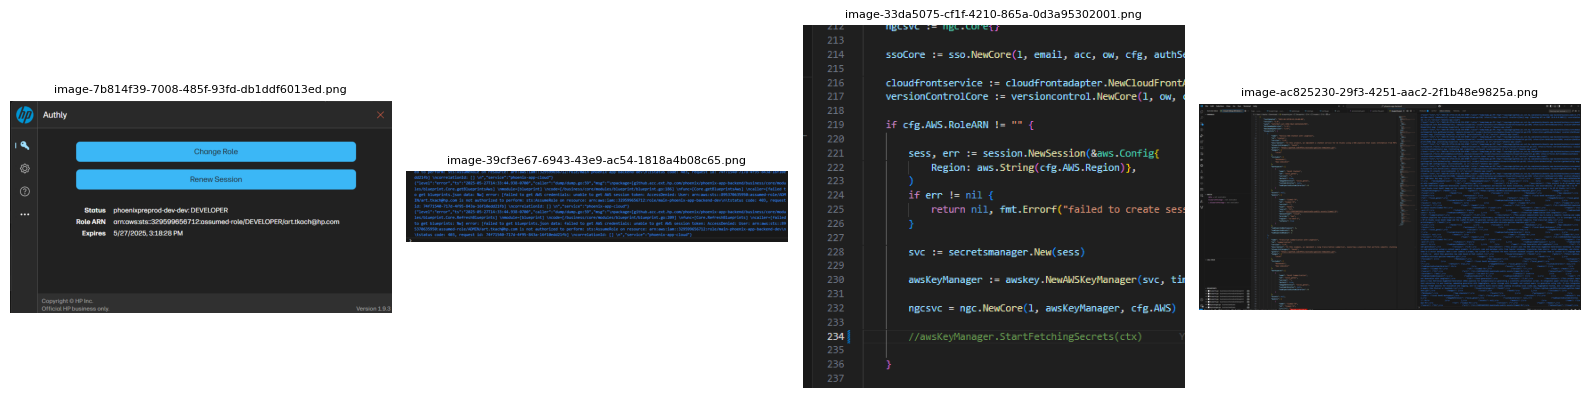

CPU times: user 41.8 s, sys: 6.22 s, total: 48 s
Wall time: 50.1 s


In [19]:
%%time

question = "How do i run blueprints locally?"
results = mm.generate(question, force_regenerate=True)

print("--- MODEL RESPONSE ---")
display(Markdown(results["reply"]))
print("----------------------\n")

display_images(results["used_images"])

2025-07-29 18:25:32 - INFO - Forced regeneration for query: 'What are some feature flags in AIStudio?'. Clearing old cache entry.
2025-07-29 18:25:32 - INFO - CACHE MISS for query: 'What are some feature flags in AIStudio?'. Running full pipeline.


--- MODEL RESPONSE ---


### Visual Analysis
The image shows a PowerShell command to add a feature flag (`hooh flags add prometheus-eap2-sso`) and the location where feature flags are stored (`"C:\Users\USER_NAME\AppData\Local\HP\AIStudio\features.yaml"`).

### Synthesized Answer
Some is an example of a feature flag in AIStudio: `prometheus-eap2-sso`. Feature flags can be added or removed using commands like `hooh flags add` and `hooh flags remove`.

### Source Documents
- [`How-to-generate-new-feature-flag.md`](#)
- [`Development/Feature-Flags/Using-Feature-Flags-in-your-code.md`](#)

----------------------

🖼️ Displaying 2 image(s):


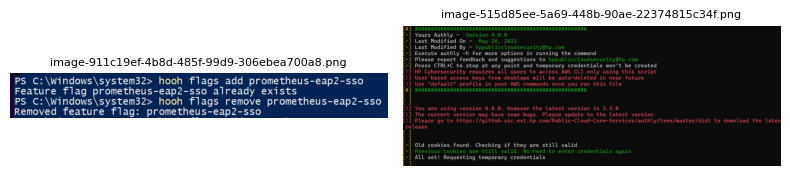

CPU times: user 15.6 s, sys: 3.1 s, total: 18.7 s
Wall time: 18.4 s


In [20]:
%%time

question2 = "What are some feature flags in AIStudio?"
results = mm.generate(question2, force_regenerate=True)

print("--- MODEL RESPONSE ---")
display(Markdown(results["reply"]))
print("----------------------\n")

display_images(results["used_images"])

2025-07-29 18:25:51 - INFO - Forced regeneration for query: 'How do i manually clean my environment without hooh?'. Clearing old cache entry.
2025-07-29 18:25:51 - INFO - CACHE MISS for query: 'How do i manually clean my environment without hooh?'. Running full pipeline.


--- MODEL RESPONSE ---


### Visual Analysis
The user provided two images. The first image shows the Windows Credentials Manager, where you can see "WebCredentials" and "WindowsCredentials". The second image is a screenshot of an AIStudio directory structure with directories like "Account ID", "db", and "creds".

### Synthesized Answer
To manually clean your environment without using Hooh, follow these steps:

1. **Access the AIStudio Directory:**
   - Open File Explorer.
   - Type `%localappdata%` in the address bar to navigate to the local app data folder.

22 Go to the HP directory and then AiStudio:**  
- In the AIStudio directory, delete the directories that have either an Account ID, db, or creds directories as circled below. Also delete the userconfig file, as it stores environment-specific variables.

3. **Remove Saved Credentials:**
   - Search for "Windows Credentials" in the Start menu.
   - Open the Windows Credential Manager.
   - Select "Windows Credentials".
   - Remove both `hp-aistudio-app` and `hp-aistudio-mongodb`.

These steps will help remove specific credentials and configurations from your environment.

### Source Documents
- How-to-manual-clean-your-environment.md

----------------------

🖼️ Displaying 4 image(s):


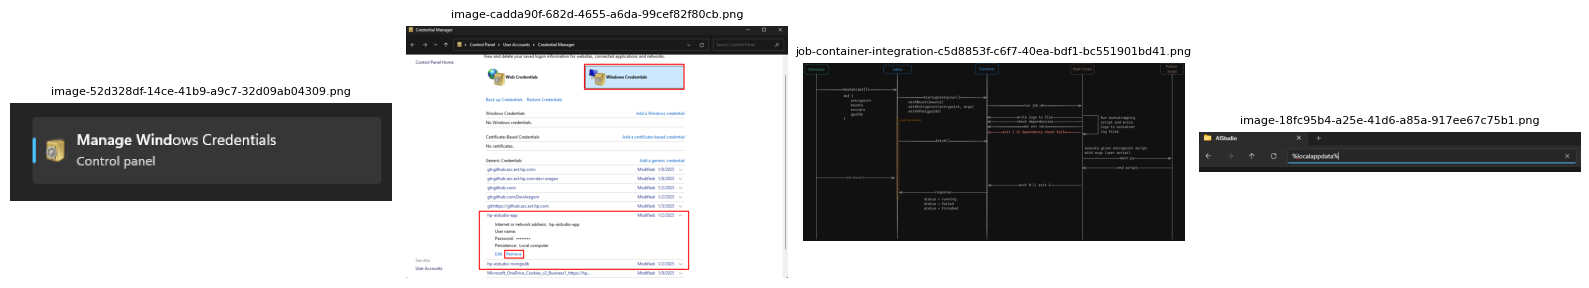

CPU times: user 27.9 s, sys: 5.11 s, total: 33 s
Wall time: 32.8 s


In [21]:
%%time

question3 = "How do i manually clean my environment without hooh?"
results = mm.generate(question3, force_regenerate=True)

print("--- MODEL RESPONSE ---")
display(Markdown(results["reply"]))
print("----------------------\n")

display_images(results["used_images"])

2025-07-29 18:26:23 - INFO - Forced regeneration for query: 'How do i sign a config file?'. Clearing old cache entry.
2025-07-29 18:26:23 - INFO - CACHE MISS for query: 'How do i sign a config file?'. Running full pipeline.


--- MODEL RESPONSE ---


### Visual Analysis
The image shows a command prompt with an error message indicating that the application requested panic due to an invalid signature in the config file. The user is trying to install Phoenix and encountered this issue.

### Synthesized Answer
To sign a config file, follow these steps:

1. **Sign In:** Sign in with authly.
2 2-Sign in with authly](/How%2Dto-articles/How-to-access-AWS-at-HP-\(authly\)), choose the `phoenix-dsp-sandbox` account.
2

2-Remember{Sign the config file with `hooh config sign PATH_TO_YOUR_CONFIG_FILE`
3. Validate the signature with `hooh config validate PATH_TO_YOUR_CONFIG_FILE`.
4 e.g., `hooh config validate C:\Users\grant\AppData\Local\HP\AIStudio\config.yaml`.

### Source Documents
- [`Development/Workarounds/Invalid-signature-in-config-file.md`](https://github.com/AIStudio/Documentation/blob/main/Development/Workarounds/Invalid-signature-in-config-file.md)
- [`How%2Dto-articles/How-to-update-&-sign-config.yaml.md`](https://github.com/AIStudio/Documentation/blob/main/How%2Dto-articles/How-to-update-&-sign-config.yaml.md)

----------------------

🖼️ Displaying 1 image(s):


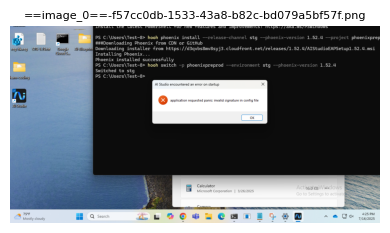

CPU times: user 26.9 s, sys: 4.48 s, total: 31.3 s
Wall time: 31.2 s


In [22]:
%%time

question4 = "How do i sign a config file?"
results = mm.generate(question4, force_regenerate=True)

print("--- MODEL RESPONSE ---")
display(Markdown(results["reply"]))
print("----------------------\n")

display_images(results["used_images"])

In [23]:
end_time: float = time.time()
elapsed_time: float = end_time - start_time
elapsed_minutes: int = int(elapsed_time // 60)
elapsed_seconds: float = elapsed_time % 60

logger.info(f"⏱️ Total execution time: {elapsed_minutes}m {elapsed_seconds:.2f}s")
logger.info("✅ Notebook execution completed successfully.")

2025-07-29 18:26:55 - INFO - ⏱️ Total execution time: 8m 52.73s
2025-07-29 18:26:55 - INFO - ✅ Notebook execution completed successfully.


Built with ❤️ using Z by HP AI Studio.